In [1]:
from transformers import AutoConfig, LlamaForCausalLM, AutoModelForCausalLM
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from vicuna_llava import llava, dataset_pretrain, dataset_instruct
from accelerate import Accelerator
accelerator = Accelerator()

Log in to huggingface (using llama requires you to request access on huggingface)

In [2]:
from huggingface_hub import login
login()

### Instantiate llava

In [3]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# grab llama
model_name = "meta-llama/Llama-3.2-1B"#"lmsys/vicuna-7b-v1.5"
#config = AutoConfig.from_pretrained(model_name)
# Grab config from the stage 2 pretrain folder
config = AutoConfig.from_pretrained("Finetuned")

# instantiate the model like normal
llamallava = accelerator.prepare(llava(config, llmURL=model_name, accelerator=accelerator))
state_dict = torch.load("Finetuned/llamallava_stage2_epoch3.pt")
llamallava.load_state_dict(state_dict, strict=False)
del state_dict

C:\Users\colli\AppData\Local\Temp\ipykernel_8700\1951567846.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("Finetuned/llamallava_stage2_epoch3.

### Instantiate Dataset

In [4]:
# directories pointing to images directory and chat.json, I've downloaded the dataset locally to deal with some of the missing images
chat = 'CC3M/chat.json'
im_dir = "CC3M/images/"

num_samples=590000
subset_idcs = list(range(num_samples))

cc3m_dataset = accelerator.prepare(Subset(dataset_pretrain(chat, im_dir), subset_idcs))
batch_size=1
#cc3m_dataloader =  accelerator.prepare(DataLoader(cc3m_dataset, batch_size=batch_size))

im_dir_instruct = 'train2017/train2017/'
chat_instruct = 'LLaVA_Instruct_150k/llava_instruct_150k.json'
instruct_dataset = accelerator.prepare(dataset_instruct(chat_instruct,im_dir_instruct,llamallava.vision_tower))
#instruct_dataloader = accelerator.prepare(DataLoader(instruct_dataset, batch_size=batch_size))

Test Generating on Some Sample from Dataset

c:\Users\colli\OneDrive\Documents\Classes\UofM\ECE 598 (LLMs)\Final Project\llava_finalproject\llava_finalproject\vicuna_llava.py:108: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


input prompt: Offer a succinct explanation of the picture presented.
llava: -length skirt with a fitted top and heels. The skirt is a light blue color with a pattern of
ground truth: all about the denim skirt right now .


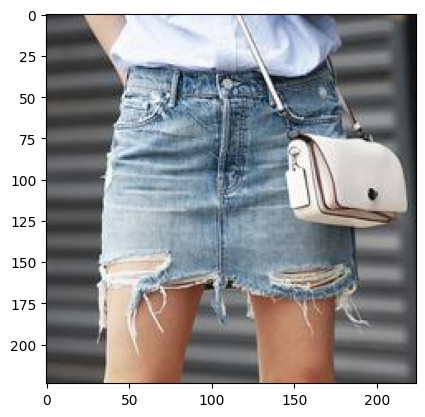

In [5]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, ToTensor
ToPIL = ToPILImage(mode='RGB')
rand_sample_idx = np.random.randint(low=0,high=len(cc3m_dataset))

# grab random sample from dataset
testprompt, testimage, testresponse = cc3m_dataset[rand_sample_idx]
testimage = testimage.to(device)

output = llamallava.generate(testimage, testprompt, max_new_tokens=20)
imagetoken = '<image>'
newlinetoken = '\n'
print(f'input prompt: {testprompt.replace(imagetoken,"").replace(newlinetoken,"")}')
print(f'llava: {output}')
print(f'ground truth: {testresponse}')
plt.imshow(ToPIL(testimage))

Test generating on LlavaInstruct dataset

input prompt: Write a detailed description of the given image.
llava: veloping city with a mix of buildings and structures. The image shows a busy street with a variety of shops, restaurants,
ground truth: The image features a vibrant street market filled with people, located in an urban area. The crowded scene shows numerous shoppers and vendors interacting in a lively environment. There are multiple bicycles parked around the market area and a couple of motorcycles situated next to each other.

Various people are walking around, with some pushing carts filled with produce and other market items. There are also a couple of umbrellas visible, possibly attached to street vendor carts or being used by passersby for shade. The atmosphere is bustling with activity, exemplifying the lively nature of street markets in city alleys.


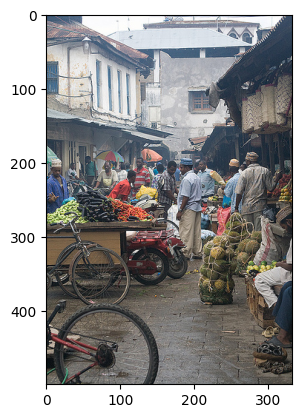

In [6]:
rand_sample_idx = np.random.randint(low=0,high=len(instruct_dataset))

# grab random sample from dataset
testprompt, testimage, testresponse = instruct_dataset.grab(rand_sample_idx)
testimage = testimage.to(device)

output = llamallava.generate(testimage, testprompt, max_new_tokens=25)
imagetoken = '<image>'
newlinetoken = '\n'
print(f'input prompt: {testprompt.replace(imagetoken,"").replace(newlinetoken,"")}')
print(f'llava: {output}')
print(f'ground truth: {testresponse}')
plt.imshow(ToPIL(testimage))

Test generating on any local image and prompt

input prompt: Describe what season this image was taken during.
llava: .png is a landscape image taken during the autumn season. The image shows a tree with a red leaf, a blue sky, and a green lawn. The tree is surrounded by a white fence, and the lawn is covered with leaves. The image is located in a park or garden, and the scene is beautiful and serene.<|end_of_text|>


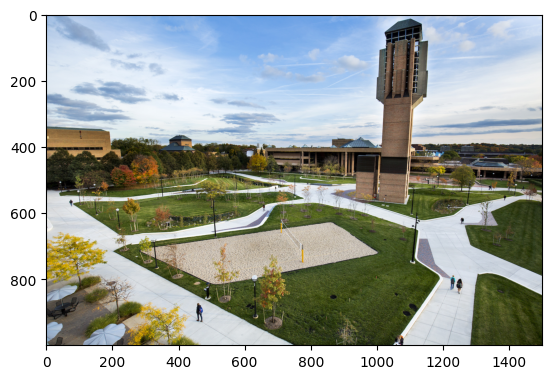

In [7]:
from PIL import Image
testprompt = 'Describe what season this image was taken during.'
testimage = Image.open('UofM_NorthCampus.jpg')

output = llamallava.generate(testimage, testprompt, max_new_tokens=100)
print(f'input prompt: {testprompt}')
print(f'llava: {output}')
plt.imshow(testimage)

input prompt: Is this a picture of real life or a video game?
llava: ughter: This is a picture of real life, as the car is a real vehicle and the person is a real person.<|end_of_text|>


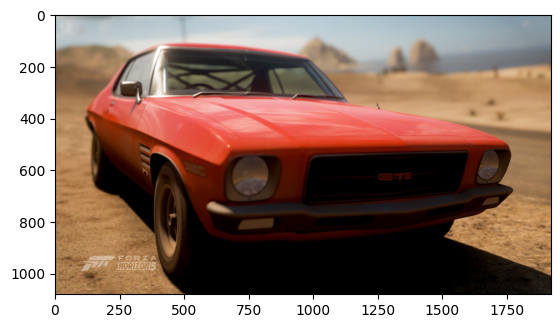

In [8]:
from PIL import Image
testprompt = 'Is this a picture of real life or a video game?'
testimage = Image.open('Forza Horizon 5 Monaro Profile Dirty.jpg')

output = llamallava.generate(testimage, testprompt, max_new_tokens=100)
print(f'input prompt: {testprompt}')
print(f'llava: {output}')
plt.imshow(testimage)

Test model on Aerial Landscapes Dataset

input prompt: You are a pilot, would you land a plane here?
llava: yes, because the plane will be able to fly through the area without any problems. The plane will be able to fly through the area without any problems, as the terrain is flat and the plane is equipped with a powerful engine. The plane will be


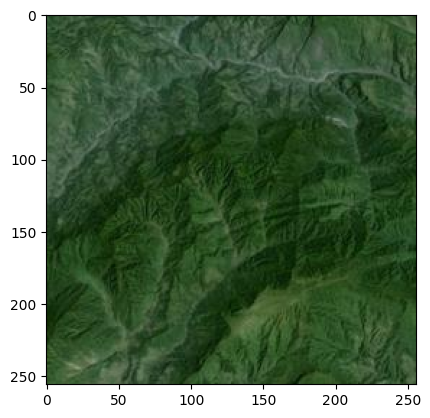

In [9]:
testprompt = 'You are a pilot, would you land a plane here?'
testimage = Image.open('Aerial_Landscapes/Mountain/799.jpg')

output = llamallava.generate(testimage, testprompt, max_new_tokens=50)
print(f'input prompt: {testprompt}')
print(f'llava: {output}')
plt.imshow(testimage)

### Training

Set which parameters to be optimized

In [10]:
from torch.optim import Adam
from transformers import get_scheduler
from tqdm.auto import tqdm



optimizer =  accelerator.prepare(Adam([{"params":llamallava.parameters(),
                                        "params":llamallava.im_embedding.parameters()}], lr=2e-3))


num_epochs = 30
gradient_accumulation_steps = 1
num_dataset_samples = len(instruct_dataloader)
num_batch_steps = num_epochs*num_dataset_samples/batch_size
num_optim_steps = num_batch_steps/gradient_accumulation_steps
num_warmup_steps = np.ceil(0.03*num_optim_steps)
lr_scheduler = accelerator.prepare(get_scheduler("cosine",
                             optimizer=optimizer,
                             num_warmup_steps=num_warmup_steps,
                             num_training_steps=num_batch_steps))


#llamallava.staged_training(instruct_dataloader,
#                            stage=2, num_epochs=num_epochs,
#                            batch_size=batch_size, grad_accu_steps=gradient_accumulation_steps,
#                            optimizer=optimizer,lr_scheduler=lr_scheduler,
#                            save_results=False,push_to_hub=False,hf_user="cjschul")



NameError: name 'instruct_dataloader' is not defined